<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Guided-Investigation---Anomalous-users-generated-by-Isolation-Forest-Model-for-SOC-Analysts" data-toc-modified-id="Guided-Investigation---Anomalous-users-generated-by-Isolation-Forest-Model-for-SOC-Analysts-1">Guided Investigation - Anomalous users generated by Isolation Forest Model for SOC Analysts</a></span><ul class="toc-item"><li><span><a href="#Notebook-initialization" data-toc-modified-id="Notebook-initialization-1.1">Notebook initialization</a></span><ul class="toc-item"><li><span><a href="#Authentication-to-LA-Workspace" data-toc-modified-id="Authentication-to-LA-Workspace-1.1.1">Authentication to LA Workspace</a></span></li></ul></li><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-1.2">Data Preparation</a></span><ul class="toc-item"><li><span><a href="#Historical-Data-Processing" data-toc-modified-id="Historical-Data-Processing-1.2.1">Historical Data Processing</a></span></li></ul></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-1.3">Feature Engineering</a></span></li><li><span><a href="#Data-Modelling" data-toc-modified-id="Data-Modelling-1.4">Data Modelling</a></span><ul class="toc-item"><li><span><a href="#Isolation-Forest-Anomaly-detection" data-toc-modified-id="Isolation-Forest-Anomaly-detection-1.4.1">Isolation Forest Anomaly detection</a></span></li></ul></li><li><span><a href="#Investigating-Anamalous-User-logon-sessions" data-toc-modified-id="Investigating-Anamalous-User-logon-sessions-1.5">Investigating Anamalous User logon sessions</a></span><ul class="toc-item"><li><span><a href="#Enter-account-name-and-query-time-window" data-toc-modified-id="Enter-account-name-and-query-time-window-1.5.1">Enter account name and query time window</a></span></li><li><span><a href="#Windows-Logon-Summary-for-the-Account" data-toc-modified-id="Windows-Logon-Summary-for-the-Account-1.5.2">Windows Logon Summary for the Account</a></span></li><li><span><a href="#Windows-Failed-Logon-Summary" data-toc-modified-id="Windows-Failed-Logon-Summary-1.5.3">Windows Failed Logon Summary</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.6">Conclusion</a></span></li></ul></li></ul></div>

# Guided Investigation - Anomalous users generated by Isolation Forest Model for SOC Analysts

 <details>
     <summary>&nbsp;<u>Details...</u></summary>

__Notebook Version:__ 1.0<br>
__Python Version:__ Python 3.8 - AzureML<br>
__Required Packages:__  Msticpy, Msticnb, matplotlib, ipywidgets <br>
__Platforms Supported:__  Azure Machine Learning Notebooks
     
__Data Source Required:__ Yes

__Data Source:__ SecurityEvents

</details>

**Description**

In this sample guided scenario notebook, we will demonstrate how to hunt for anamalous user logon activity using [Isolation forest](https://en.wikipedia.org/wiki/Isolation_forest) model. 
<br>We will start with reading historical windows logon data from Microsoft Sentinel workspace, then we will
prepocess the dataset using series of data preparation steps such as aggregation, summarization, data type conversion, deriving new fields etc. Then we will perform [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering) and select subset of features 
from the data prepared from previous steps to create isolation forest model. Finally, we will run the model to score the results and identify anomalies with higher score.

<br>The isolation forest algorithm will split the data into two parts based on random threshold value. It will recursively continue the splitting until each data point is isolated. Then we will detect anomalies using isolation (how far a data point is to the rest of the data). 
To detect an anomaly the isolation forest takes the average path length (number of splits to isolate a sample) of all the trees 
for a given instance and uses this to determine if it is an anomaly (average shorter path lengths indicate anomalies)

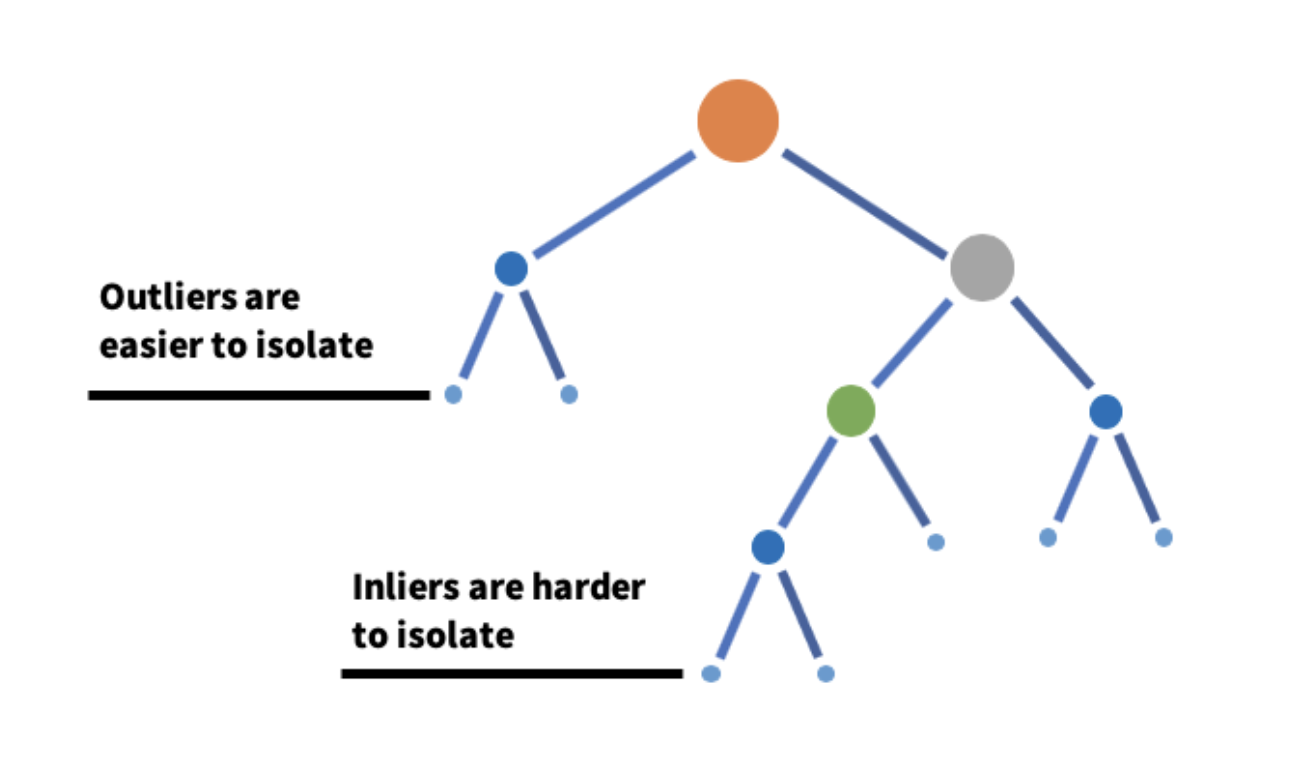

Image Credits: [Detecting and preventing abuse on LinkedIn using isolation forests](https://engineering.linkedin.com/blog/2019/isolation-forest)

***Please run the cells sequentially to avoid errors.
<br>Please do not use "run all cells".*** 

## Notebook initialization
The next cell:
- Checks for the correct Python version
- Checks versions and optionally installs required packages
- Imports the required packages into the notebook
- Sets a number of configuration options.

This should complete without errors. If you encounter errors or warnings look at the following two notebooks:
- [TroubleShootingNotebooks](https://github.com/Azure/Azure-Sentinel-Notebooks/blob/master/TroubleShootingNotebooks.ipynb)
- [ConfiguringNotebookEnvironment](https://github.com/Azure/Azure-Sentinel-Notebooks/blob/master/ConfiguringNotebookEnvironment.ipynb)

If you are running in the Microsoft Sentinel Notebooks environment (Azure Notebooks or Azure ML) you can run live versions of these notebooks:
- [Run TroubleShootingNotebooks](./TroubleShootingNotebooks.ipynb)
- [Run ConfiguringNotebookEnvironment](./ConfiguringNotebookEnvironment.ipynb)

You may also need to do some additional configuration to successfully use functions such as Threat Intelligence service lookup and Geo IP lookup. 
There are more details about this in the `ConfiguringNotebookEnvironment` notebook and in these documents:
- [msticpy configuration](https://msticpy.readthedocs.io/en/latest/getting_started/msticpyconfig.html)
- [Threat intelligence provider configuration](https://msticpy.readthedocs.io/en/latest/data_acquisition/TIProviders.html#configuration-file)

In [ ]:
from pathlib import Path
import os
import sys
import warnings
import shap
from IPython.display import display, HTML, Markdown, Javascript
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import IsolationForest
from msticpy.common.timespan import TimeSpan

REQ_PYTHON_VER = (3, 6)
REQ_MSTICPY_VER = (1, 7, 0)

display(HTML("<h3>Starting Notebook setup...</h3>"))

# You may need to manually install msticpy with
# %pip install msticpy[azsentinel]

import msticpy as mp
import msticnb as nb

mp.init_notebook(namespace=globals())

WIDGET_DEFAULTS = {
    "layout": widgets.Layout(width="95%"),
    "style": {"description_width": "initial"},
}

### Authentication to LA Workspace
 <details>
     <summary>&nbsp;<u>Details...</u></summary>
If you are using user/device authentication, run the following cell. 
- Click the 'Copy code to clipboard and authenticate' button.
- This will pop up an Azure Active Directory authentication dialog (in a new tab or browser window). The device code will have been copied to the clipboard. 
- Select the text box and paste (Ctrl-V/Cmd-V) the copied value. 
- You should then be redirected to a user authentication page where you should authenticate with a user account that has permission to query your Log Analytics workspace.

Use the following syntax if you are authenticating using an Azure Active Directory AppId and Secret:
```
%kql loganalytics://tenant(aad_tenant).workspace(WORKSPACE_ID).clientid(client_id).clientsecret(client_secret)
```
instead of
```
%kql loganalytics://code().workspace(WORKSPACE_ID)
```

Note: you may occasionally see a JavaScript error displayed at the end of the authentication - you can safely ignore this.<br>
On successful authentication you should see a ```popup schema``` button.
To find your Workspace Id go to [Log Analytics](https://ms.portal.azure.com/#blade/HubsExtension/Resources/resourceType/Microsoft.OperationalInsights%2Fworkspaces). Look at the workspace properties to find the ID.
</details>

In [ ]:
# See if we have a Microsoft Sentinel Workspace defined in our config file.
# If not, let the user specify Workspace and Tenant IDs

ws_config = WorkspaceConfig(workspace="Default")
if not ws_config.config_loaded:
    ws_config.prompt_for_ws()
    
qry_prov = QueryProvider(data_environment="MSSentinel")
# Authentication
qry_prov.connect(ws_config)
table_index = qry_prov.schema_tables

## Data Preparation
In this step, we will prepare the Windows logon events and do some preprocessing before we do data modelling. For this case, we are primarily considering logon event ids 4624, 4625 with specific logon type. 

4624 and 4625 events are related to Successful sign in and Failed Sign-in. You can check more about the event Ids in below links.

- [4624(S): An account was successfully logged on.](https://docs.microsoft.com/windows/security/threat-protection/auditing/event-4624)
- [4625(F): An account failed to log on.](https://docs.microsoft.com/windows/security/threat-protection/auditing/event-4625)

### Historical Data Processing
For this model, we can consider upto 21 days of historical data. If you want to generate this anomalies on recurrent basis then depending on scale and volume of the data, you can set up intermediate pipeline to save historical data into custom table and load results from it. 
Check out the blog for ways to export historical data at scale using notebook [Export Historical Log Data from Microsoft Sentinel](https://techcommunity.microsoft.com/t5/microsoft-sentinel-blog/export-historical-log-data-from-microsoft-sentinel/ba-p/3413418)
For this demo, we are retrieving data from the original table. We also have provided demo dataset if you want to test the notebook without connecting to your workspace.

In [ ]:
win_agg_query = '''
let start = 21d;
let end = 1d;
SecurityEvent
| where TimeGenerated >= startofday(ago(start)) and TimeGenerated <= endofday(ago(end))
| where EventID in (4624, 4625)
| where LogonTypeName == "3 - Network"
| extend DstDomain=TargetDomainName, DstUser=TargetUserName, Date = format_datetime(TimeGenerated, 'yyyy-MM-dd')
| where not (EventID == 4624 and (DstDomain =~ "NT AUTHORITY" or DstDomain =~ "ANONYMOUS LOGON") and LogonType == "3")
| where not (EventID == 4624 and (DstDomain =~ "NT AUTHORITY" or DstDomain =~ "SYSTEM") and LogonType == "5")
| where not (EventID == 4624 and DstDomain =~ "WINDOW MANAGER" and DstUser startswith "DWM-" and LogonType == "2")
| where not (EventID == 4624 and DstDomain =~ "NT VIRTUAL MACHINE")
| where DstUser !endswith "$"
| summarize AttemptedLogons = count() , MAX_TimeGenerated = max(TimeGenerated), MIN_TimeGenerated = min(TimeGenerated), SuccessfulLogons=countif(EventID == 4624), FailedLogons=countif(EventID == 4625), ComputerDomainsAccessed=dcount(TargetDomainName), DistinctAuthenticationPackage=dcount(AuthenticationPackageName), ComputersAccessed = dcount(Computer), DistinctSrcIp= dcount(IpAddress), DistinctSrcHostName = dcount(Workstation), ComputersSuccessfulAccess = dcountif(Computer, EventID == 4624),  ComputerDomainsSuccessfulAccess = dcountif(AccountDomain, EventID == 4624), SrcIpSuccessfulAccess = dcountif(IpAddress, EventID == 4624), SrcHostNameSuccessfulAccess = dcountif(WorkstationName, EventID ==4624) by Date, DstDomain, DstUser, LogonTypeName
| extend ActiveMilliseconds = datetime_diff('millisecond', MAX_TimeGenerated, MIN_TimeGenerated)'''

win_agg_df = qry_prov.exec_query(win_agg_query)

# Uncomment below lines if you want to test the notebook with demo dataset
# dataset_url = "https://raw.githubusercontent.com/Azure/Azure-Sentinel-Notebooks/master/src/data/iforest-demo-data.csv"
# win_agg_df = pd.read_csv(dataset_url)
# win_agg_df.head()

In [ ]:
#Displaying the columns of the data loaded from previous step.
win_agg_df.info()

In [ ]:
# Displaying the no of records
win_agg_df.shape

## Feature Engineering

In this step, we are creating additional features/columns. 

We have selected 4 columns(features) with numeric data points 
- FailedLogons
- SuccessfulLogons
- ComputersSuccessfulAccess
- SrcIpSuccessfulAccess

and also deriving additional columns by calculating mean, standard deviation and zscores on each of them. Converting to zscores is not necessary for numerical features as Isolation forest are scale invariant but this pre-processing is done so as to use these features later in the visualizations such as PCA.  We have also done log scaling as part of data pre-processing steps which is not required but based on various data studies in production environment we have seen it gives finer results. You can skip or add this step based on data study and analyzing results.

In [ ]:
def get_zscore(value, mean, std):
    # calculate z-score or number of standard deviations from mean
    if (
        std == 0
        or std is None
        or str(std).lower() in ["nan", "none", "null"]
        or mean is None
    ):
        if value == 0.0:
            return 0.0
        elif value != 0:
            return np.log10(value + 1)
    ans = (value - mean) / std
    # only interested in increases
    ans = max(0.0, ans)
    # take log to dampen numbers
    ans = np.log10(ans + 1)
    return float(ans)


data = win_agg_df.copy()

zscore_columns = [
    "FailedLogons",
    "SuccessfulLogons",
    "ComputersSuccessfulAccess",
    "SrcIpSuccessfulAccess",
]
means = [x + "_mean" for x in zscore_columns]
stds = [x + "_std" for x in zscore_columns]
zscores = [x + "_zscore" for x in zscore_columns]

ind = ["DstDomain", "DstUser", "Date"]

zscore = data[zscore_columns + ind]
zscore = zscore.fillna(0)

# getting means for user, domain and logon type combination
zscore[means] = zscore.groupby(["DstDomain", "DstUser"])[zscore_columns].transform(
    "mean"
)

# getting standard deviation for user, domain and logon type combination
zscore[stds] = zscore.groupby(["DstDomain", "DstUser"])[zscore_columns].transform(
    "std", ddof=1
)

zscore = zscore.drop_duplicates(["DstDomain", "DstUser"])

zscore = zscore[means + stds + ["DstDomain", "DstUser"]]

data = data.merge(zscore, how="left", on=["DstDomain", "DstUser"])

# Calculating z scores
for column in zscore_columns:
    data[f"{column}_zscore"] = data.apply(
        lambda row: get_zscore(
            row[f"{column}"], row[f"{column}_mean"], row[f"{column}_std"]
        ),
        axis=1,
    )
# Display top 10 record
data.head()

In [ ]:
data.info()

## Data Modelling
In this step we will specify features to be modelled and run isolation forest algorithm against the data.

###  Isolation Forest Anomaly detection

In this step, we will select subset of features generated from previous step and use it for data modelling. We will also use Isolation Forest model on the data with selected features and calculate the anomalies. 

In [ ]:
def apply_isolation_forest(df, n_estimators, contamination=0.01):
    """Applies Isolation Forest to a given dataset and returns the predicted anomalies."""
    clf = IsolationForest(
        n_estimators=n_estimators,
        max_samples="auto",
        contamination=contamination,
        max_features=6,
        bootstrap=False,
        n_jobs=-1,
        random_state=42,
        verbose=0,
    )
    clf.fit(df.values)
    pred = clf.predict(df.values)
    scores = clf.decision_function(df.values)
    return clf, pred, scores

# specify the metrics column names to be modelled
features = [
    "FailedLogons_zscore",
    "SuccessfulLogons_zscore",
    "ComputersSuccessfulAccess_zscore",
    "ComputerDomainsSuccessfulAccess",
    "SrcIpSuccessfulAccess_zscore",
    "SrcHostNameSuccessfulAccess",
]

data[features] = data[features].fillna(0)

X = data[features].copy()
if X.shape[0] < 500:
    n_estimators = len(features) * 4 + X.shape[0] * 2
else:
    n_estimators = 100

# n_estimators = 100
print("Number of trees", n_estimators)

clf, pred, scores = apply_isolation_forest(X, n_estimators, contamination=0.01)
data["anomaly"] = pred
data["score"] = scores * -1
# excluding users who do not have any successful logon history.
data = data.loc[data["SuccessfulLogons"] > 0]
outliers = data.loc[data["anomaly"] == -1]
outlier_index = list(outliers.index)
print(f"Outliers at indexes: {outlier_index}")
# Find the number of anomalies and normal points here points classified -1 are anomalous
print(data["anomaly"].value_counts())

In [ ]:
print("Number of outliers:", outliers.shape[0])
print("Top anomalies by score (top most has highest anomaly score and so on)")
outliers = outliers.sort_values(by=["score"], ascending=False)
display(outliers.head())

## Investigating Anamalous User logon sessions

In [ ]:
def get_index(df, domain, user, date):

    # Use the "loc" method to select rows that match the criteria
    rows = df.loc[
        (df["DstDomain"] == domain) & (df["DstUser"] == user) & (df["Date"] == date)
    ]

    # Check if there are any matching rows
    if len(rows) == 0:
        print("No matching rows found")
        return None

    # Return the index of the first matching row
    return rows.index[0]

# uncomment and replace user values based on your dataset and dates
# outlier_index1 = get_index(data, "CONTOSO", "SRVACC-04", "9/16/2022")
# outlier_index2 = get_index(data, "CONTOSO", "SVC-ACC-02", "9/25/2022")
# print(
#     f"ourlier1 is at index: {outlier_index1} and \noutlier2 is at index: {outlier_index2}"
# )

In [ ]:
explainer = shap.TreeExplainer(clf)  # Explainer
X = data[features].copy()
shap_values = explainer.shap_values(X)  # Calculate SHAP values

In [ ]:
shap.initjs()  # initialisation of Javascript to load visualization
# populate outlier_index1 based on above code or replace directly with index numbers
shap.force_plot(
    explainer.expected_value,
    shap_values[outlier_index1],
    features=X.iloc[outlier_index1, :],
    feature_names=X.columns,
)

Based on the output of local outlier feature importance  
 - Gather the respective values from the historical dataset
 - Analyze/plot the results 
 - Investigate for any malicious activity

In [ ]:
outlier_data = data[data['DstUser']=="SRVACC-04"]
outlier_data['Date'] = pd.to_datetime(outlier_data['Date'])
outlier_data.set_index('Date', inplace=True)

# Plot a line chart of the "FailedLogons" column
ax = outlier_data.plot(kind="line", color= 'red', y="FailedLogons")
outlier_data.plot(kind="line", color ='green', y="SrcHostNameSuccessfulAccess", ax= ax)

# Set the x-axis label and title
plt.xlabel("Date")
plt.title("Trend of Failed Logons and SrcHostNameSuccessfulAccess Per Day for user SRVACC-04", fontsize=12)
# Set the legend to the upper right corner
plt.legend(["FailedLogons", "SrcHostNameSuccessfulAccess"], loc="upper right" , fontsize=8)

# Set the figure size to 8 inches by 5 inches
plt.rcParams["figure.figsize"] = (10,8)

# Show the plot
plt.show()

You can also further use msticpy nblets to gather account information from various datasets.
Below is an example for account nblet

### Enter account name and query time window
Type the account name that you want to search for and the time bounds over which you want to search. 

You can specify the account as:

- a simple user name (e.g. `alice`)
- a user principal name (`alice@contoso.com`)
- a qualified windows user name `mydomain\alice`

In the second two cases the domain qualifier will be stripped off before the search. The search is not case sensitive and will match full substrings. E.g. `bob` will match `domain\bob` and `bob@contoso.com` but not `bobg` or `bo`.

In [ ]:
WIDGET_DEFAULTS = {
    "layout": widgets.Layout(width="95%"),
    "style": {"description_width": "initial"},
}
accountname_text = widgets.Text(description='Enter the Account name to search for:', **WIDGET_DEFAULTS)
display(accountname_text)

In [ ]:
import msticnb as nb
nb.init(query_provider="AzureSentinel")

In [ ]:
nb.browse()

In [ ]:
account_summary = nb.nblts.azsent.account.AccountSummary()
qt = mp.nbwidgets.QueryTime(auto_display=True)

In [ ]:
account_summary_rslt = account_summary.run(value=accountname_text.value, timespan=TimeSpan(qt))

### Windows Logon Summary for the Account

In [ ]:
qry_prov.WindowsSecurity.list_logons_by_account('?')

In [ ]:
qt.start

In [ ]:
qry_prov.WindowsSecurity.list_logons_by_account(start=qt.start, end=qt.end, account_name=accountname_text.value)

### Windows Failed Logon Summary

In [ ]:
qry_prov.WindowsSecurity.list_logon_failures_by_account(start=qt.start, end=qt.end, account_name=accountname_text.value)

## Conclusion

In this notebook, we started with windows event logs login data with the goal of finding users with anomalous login patterns. This notebook is targetted towards SOC Analysts who can use it to take anomalous user logon session generated from Isolation Forest model and investigate further. We can use the AccountSummary notebooklet to gather various information associated with the account such as associated alerts, bookmarks , entries from ActiveDirectory, Windows and Linux Host logs. 